In [1]:
import numpy as np
from bikewheelcalc import BicycleWheel, Rim, Hub, Spoke
import pandas as pd
import bikewheellib as bl
import matplotlib.pyplot as plt
from doetools import LateralStiffnessDOE

from IPython.display import display

%matplotlib inline

pd.set_option('precision', 2)

In [2]:
out_dir = '../data/doe/doe_Klat_tension'

if False:
    # Create ABAQUS simulations
    R = 0.300
    GJ = 25.0
    EI1 = 100.
    EI2 = GJ / 0.2

    doe = LateralStiffnessDOE(out_dir=out_dir,
                              opts={'spk_paired': False, 'spk_eltype': 'beam'})

    wh = BicycleWheel()
    wh.hub = Hub(diam1=0.05, width1=0.025, width2=0.025)
    wh.rim = Rim(radius=R, area=100e-6,
                 I11=GJ / 26.0e9, I22=EI2 / 26.0e9, I33=EI1 / 26.0e9, Iw=0.0 / 69.0e9,
                 young_mod=69.0e9, shear_mod=26.0e9)

    wh.lace_radial(n_spokes=36, diameter=1.8e-3, young_mod=200e9, offset=0.00)
    
    rr = bl.ModeMatrix(wh, N=36)
    
    print rr.buckling_tension(smeared_spokes=True, coupling=False)

    tension = np.linspace(0., 1900., 20)
    for t in tension:
        jobname = 'Klat_T{:.0f}'.format(t)
        doe.add_experiment(wh, opts={'jobname': jobname, 'spk_T': t})

    print('\nCreated {0:d} simulations'.format(len(doe.db)))

    doe.write_input_files(N_batches=2)
    doe.to_csv()

In [3]:
if True:

    # Load DOE database
    print 'Loading database...'
    doe = LateralStiffnessDOE(out_dir=out_dir, db_file=out_dir+'/_doe_db.csv')

    # Populate DOE database with results
    print 'Extracting results...'
    d = doe.extract_results()
    print '\nDone'

Loading database...
Extracting results...
....................
Done


In [4]:
def rr_lateral_stiffness(r, smeared_spokes=True, buckling=True, coupling=True):
    w = doe.wheel_from_row(r)
    
    w.apply_tension(r['spk_T'] + 0.01)

    rr = bl.ModeMatrix(w, N=36)
    
    return rr.calc_lat_stiff(smeared_spokes=smeared_spokes,
                             buckling=buckling,
                             coupling=coupling)

if True:
    doe.db['K_lat_cp_sm'] = doe.db.apply(lambda x: rr_lateral_stiffness(x, smeared_spokes=True, coupling=True), axis=1)
    doe.db['K_lat_cp_ds'] = doe.db.apply(lambda x: rr_lateral_stiffness(x, smeared_spokes=False, coupling=True), axis=1)
    doe.db['K_lat_nc_sm'] = doe.db.apply(lambda x: rr_lateral_stiffness(x, smeared_spokes=True, coupling=False), axis=1)

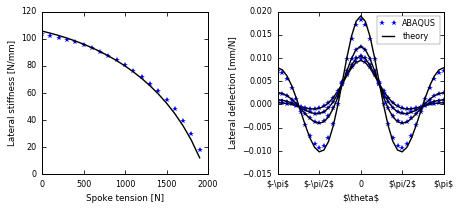

In [5]:
def d_symm(y):
    n = len(y)
    return np.concatenate((y[n/2:], y[:(n/2+1)]))

def u3_theor(r, theta):
    'Get theroetical deformed shape'
    w = doe.wheel_from_row(r)
    
    w.apply_tension(r['spk_T'] + 0.01)

    rr = bl.ModeMatrix(w, N=36)
    
    # External forces
    F_ext = rr.calc_F_ext(np.array([0.]),
                          np.array([[1., 0., 0., 0.]]))

    K = rr.calc_K_rim(buckling=True) + rr.calc_K_spk(smeared_spokes=True)
    d = np.linalg.solve(K, F_ext)
    
    u3 = np.zeros(theta.shape)
    
    for i, t in enumerate(theta):
        u3[i] = rr.B_theta(t).dot(d)[0]
    
    return u3

with plt.style.context(('seaborn-paper')):

    fig, ax = plt.subplots(ncols=2, figsize=(6.5, 3))

    ax[0].plot(doe.db['spk_T'], doe.db['K_lat_abq'] / 1000, 'b*')
    ax[0].plot(doe.db['spk_T'], doe.db['K_lat_nc_sm'] / 1000, 'k')

    ax[0].set_xlabel('Spoke tension [N]')
    ax[0].set_ylabel('Lateral stiffness [N/mm]')
    
    theta = np.linspace(-np.pi, np.pi, 37)
    
    ax[1].plot([], color='blue', marker='*', linestyle='none', label='ABAQUS')
    ax[1].plot([], color='black', label='theory')
    
    for t in [0., 500., 1000., 1500.]:
        r = doe.db[doe.db['spk_T'] == t].iloc[0]

        s = pd.read_csv(out_dir + '/' + r['jobname'] + '_shape.csv', header=1)
        u3 = s.loc[2].values[2:]
        ax[1].plot(theta, d_symm(u3) * 1000., 'b*')
        
        ax[1].plot(theta, u3_theor(r, theta) * 1000, 'k')

    ax[1].set_xlabel(r'\$\theta\$')
    ax[1].set_ylabel('Lateral deflection [mm/N]')
        
    ax[1].set_xlim([-np.pi, np.pi])
    ax[1].set_xticks([-np.pi, -np.pi/2, 0., np.pi/2, np.pi])
    ax[1].set_xticklabels([r'\$-\pi\$', r'\$-\pi/2\$','0', r'\$\pi/2\$', r'\$\pi\$'])
    
    ax[1].legend()
    
    plt.tight_layout()
    plt.savefig('../figs/stress_analysis/_python_Klat_tension.pdf')
    plt.show()